<a href="https://colab.research.google.com/github/hasanasyarie/Project-Dicoding/blob/main/Time_Series_Yahoo_Stock_Predictions_using_LSTM_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**Intro**

Pada notebook kali ini saya membuat proyek untuk melakukan prediksi data time series saham Yahoo menggunakan dataset yang saya peroleh dari kaggle.

####**Import Library**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

####**Load Dataset**

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hasanasyarie/Data/main/yahoo_stock.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [ ]:
# Melihat dimensi data
df.shape

(1825, 7)

In [ ]:
# Melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [ ]:
# Mengecek data kosong
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

####**Plotting Data**

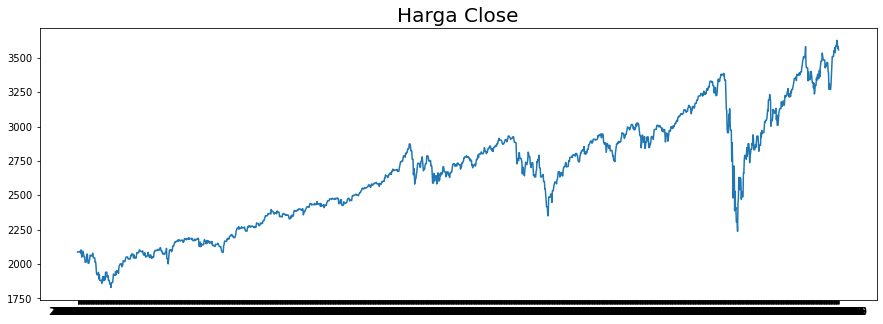

In [ ]:
dates = df['Date'].values
close  = df['Close'].values

plt.figure(figsize=(15,5))
plt.plot(dates, close)
plt.title('Harga Close', fontsize=20);

####**Normalisasi Data**

In [ ]:
df = df.drop(columns=['Date'])

In [ ]:
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.head()

,High,Low,Open,Close,Volume,Adj Close
0,0.138194,0.151554,0.143932,0.143234,0.295740,0.143234
1,0.137366,0.145353,0.141126,0.144652,0.334066,0.144652
2,0.136743,0.154297,0.143870,0.144502,0.200874,0.144502
3,0.136743,0.154297,0.143870,0.144502,0.200874,0.144502
4,0.136905,0.153084,0.143600,0.145192,0.021979,0.145192


####**Membagi Data Training dan Testing**

In [ ]:
close_norm  = df_norm['Close'].values

In [ ]:
x_train, x_test = train_test_split(close_norm, test_size=0.2, shuffle=False)

####**Membuat Fungsi untuk Mengubah Format Data**

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

####**Membangun Model LSTM**

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

**Memanfaatkan Fungsi Callback**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE telah mencapai < 10% skala data!")
      self.model.stop_training = True
callbacks = myCallback()

**Compile Model**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

**Training Model**

In [ ]:
history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=50,
                    callbacks=[callbacks],
                    verbose=2)

Epoch 1/50
14/14 - 10s - loss: 0.0663 - mae: 0.3312 - val_loss: 0.1564 - val_mae: 0.5430 - 10s/epoch - 747ms/step
Epoch 2/50
14/14 - 4s - loss: 0.0318 - mae: 0.2235 - val_loss: 0.0559 - val_mae: 0.3194 - 4s/epoch - 285ms/step
Epoch 3/50

MAE telah mencapai < 10% skala data!
14/14 - 4s - loss: 0.0041 - mae: 0.0697 - val_loss: 0.0041 - val_mae: 0.0564 - 4s/epoch - 286ms/step


####**Plotting Loss dan MAE**

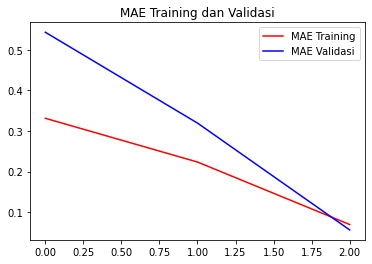

<Figure size 432x288 with 0 Axes>

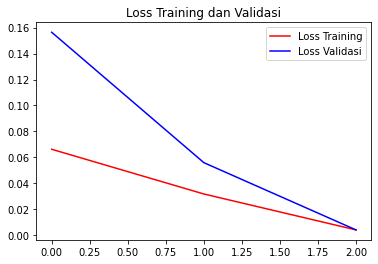

<Figure size 432x288 with 0 Axes>

In [ ]:
mae = history.history['mae'] 
val_mae = history.history['val_mae']      
loss = history.history['loss']             
val_loss = history.history['val_loss']    

epochs = range(len(mae))                                 

plt.plot(epochs, mae, 'r', label = 'MAE Training')             
plt.plot(epochs, val_mae, 'b', label = 'MAE Validasi')    
plt.title('MAE Training dan Validasi')                    
plt.legend(loc = 0)                                         
plt.figure()                                             
plt.show()                                                  

plt.plot(epochs, loss, 'r', label = 'Loss Training')           
plt.plot(epochs, val_loss, 'b', label = 'Loss Validasi')        
plt.title('Loss Training dan Validasi')                      
plt.legend(loc = 0)           
plt.figure()                 
plt.show()            